In [2]:
import os 
import sys 
sys.path.append("../training")
import pickle

import hashlib
import hls4ml 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, Softmax
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
import tensorflow_model_optimization as tfmot

from qkeras.qlayers import QDense, QActivation
from qkeras import QBatchNormalization
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.utils import _add_supported_quantized_objects
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

2024-08-20 14:47:38.835816: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-20 14:47:38.935589: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-20 14:47:38.935607: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-08-20 14:47:39.434533: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'


/home/jcampos/miniforge3/envs/ml4qick-env/lib/python3.8/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


## Load Data

#### Impoartant! 
Download the dataset locally from [OneDrive here](https://purdue0-my.sharepoint.com/personal/du245_purdue_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fdu245%5Fpurdue%5Fedu%2FDocuments%2FShared%2FQSC%20ML%20for%20readout%2FFinal%5Fraw%5Fdata%5Ffor%5Fpaper%2Fdata%5F0528%5Fnpy). We are using QICK data with timestamp **0528**. 

In [41]:
def one_hot_encode(data):
    y_encoded = np.zeros([data.shape[0],2], dtype=np.int32)
    for idx, x in enumerate(data):
        if x == 1:
            y_encoded[idx][1] = 1
        else:
            y_encoded[idx][0] = 1
    return y_encoded

In [42]:
"""Loadning training split"""
start_window = 0
end_window = 770
data_dir = "../data/malab_05282024/npz/"
assert os.path.exists(f"{data_dir}/0528_X_train_{start_window}_{end_window}.npy"), "File does not exist "

x_train_path = os.path.join(data_dir, f'0528_X_train_{start_window}_{end_window}.npy')
y_train_path = os.path.join(data_dir, f'0528_y_train_{start_window}_{end_window}.npy')

X_train_val = np.load(x_train_path)
y_train_val = np.load(y_train_path)

# Insure same dataset is loaded 
assert hashlib.md5(X_train_val).hexdigest() == 'b61226c86b7dee0201a9158455e08ffb',  "Checksum failed. Wrong file was loaded or file may be corrupted."
assert hashlib.md5(y_train_val).hexdigest() == 'c59ce37dc7c73d2d546e7ea180fa8d31',  "Checksum failed. Wrong file was loaded or file may be corrupted."

y_train_val = one_hot_encode(y_train_val)

print("Train Data Set:")
print("\tX Path        :", x_train_path)
print("\ty Path        :", y_train_path)
print("\tSize          :", len(X_train_val))
print("\tSample Shape  :", X_train_val[0].shape)
print("\tMean          :", X_train_val.mean())
print("\tStd. Dev.     :", X_train_val.std())

assert len(X_train_val[0]) == (end_window-start_window)*2, "ERROR: Specified window does not match loaded dataset shape"

Train Data Set:
	X Path        : ../data/malab_05282024/npz/0528_X_train_0_770.npy
	y Path        : ../data/malab_05282024/npz/0528_y_train_0_770.npy
	Size          : 900000
	Sample Shape  : (1540,)
	Mean          : 57.37779754545455
	Std. Dev.     : 844.0956096913322


In [43]:
"""Loading testing split"""
start_window = 0
end_window = 770
data_dir = "../data/malab_05282024/npz/"
assert os.path.exists(f"{data_dir}/X_test_{start_window}_{end_window}.npy"), "File does not exist "

x_test_path = os.path.join(data_dir, f'0528_X_test_{start_window}_{end_window}.npy')
y_test_path = os.path.join(data_dir, f'0528_y_test_{start_window}_{end_window}.npy')

X_test = np.load(x_test_path)
y_test = np.load(y_test_path)

# Insure same dataset is loaded 
assert hashlib.md5(X_test).hexdigest() == 'b7d85f42522a0a57e877422bc5947cde', "Checksum failed. Wrong file was loaded or file may be corrupted."
assert hashlib.md5(y_test).hexdigest() == '8c9cce1821372380371ade5f0ccfd4a2', "Checksum failed. Wrong file was loaded or file may be corrupted."

y_test = one_hot_encode(y_test)

print("Test Data Set:")
print("\tX Path        :", x_test_path)
print("\ty Path        :", y_test_path)
print("\tSize         :", len(X_test))
print("\tSample Shape :", X_test[0].shape)
print("\tSample Shape :", X_test.mean())
print("\tStd. Dev.    :", X_test.std())

assert len(X_test[0]) == (end_window-start_window)*2, "ERROR: Specified window does not match loaded dataset shape"

Test Data Set:
	X Path        : ../data/malab_05282024/npz/0528_X_test_0_770.npy
	y Path        : ../data/malab_05282024/npz/0528_y_test_0_770.npy
	Size         : 100000
	Sample Shape : (1540,)
	Sample Shape : 57.57549828571429
	Std. Dev.    : 845.6158899866076


## Multi-layer Model 
Or the initial "big" model 

<!-- ![Multi-layer model](../images/multi_layer_model.png) -->
<img src="../images/multi_layer_model.png" alt="alt text" width="75%">

In [6]:
"""hyperparameters"""
init_learning_rate = 1e-4
validation_split = 0
batch_size = 8192
epochs = 50
checkpoint_filename = "multi-layer.h5"
input_shape = (len(X_train_val[0]),)
start_window = 0
end_window = 770


In [7]:
sr = int((end_window-start_window)*2)
hn = sr * 2

model = Sequential()
model.add(Dense(int(hn/8), activation='relu', input_shape=(sr,)))
model.add(BatchNormalization())
model.add(Dense(2, activation='relu'))

print(model.summary())
assert model.count_params() == 595597, 'Error. Total parameters has changed.'

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 385)               593285    
                                                                 
 batch_normalization (BatchN  (None, 385)              1540      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2)                 772       
                                                                 
Total params: 595,597
Trainable params: 594,827
Non-trainable params: 770
_________________________________________________________________
None


2024-08-20 14:48:03.952618: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-08-20 14:48:03.952736: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-08-20 14:48:03.952777: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (correlator4.fnal.gov): /proc/driver/nvidia/version does not exist
2024-08-20 14:48:03.953182: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Train the model 

In [8]:
callbacks = [
        ModelCheckpoint(
        checkpoint_filename,
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        save_freq="epoch",
    ),
    ReduceLROnPlateau(patience=75, min_delta=1**-6),
]


In [9]:
opt = Adam(learning_rate=init_learning_rate)
model.compile(
    optimizer=opt, 
    loss=CategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

history = model.fit(
    X_train_val, 
    y_train_val, 
    batch_size=batch_size,
    epochs=epochs, 
    validation_split=0.05, 
    shuffle=True, 
    callbacks=callbacks,
)

Epoch 1/10


2024-08-20 14:48:05.339412: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 5266800000 exceeds 10% of free system memory.


105/105 [==============================] - 4s 34ms/step - loss: 0.2369 - accuracy: 0.9280 - val_loss: 0.1933 - val_accuracy: 0.9519 - lr: 1.0000e-04
Epoch 2/10
105/105 [==============================] - 3s 31ms/step - loss: 0.1742 - accuracy: 0.9569 - val_loss: 0.1756 - val_accuracy: 0.9555 - lr: 1.0000e-04
Epoch 3/10
105/105 [==============================] - 3s 32ms/step - loss: 0.1636 - accuracy: 0.9597 - val_loss: 0.1683 - val_accuracy: 0.9579 - lr: 1.0000e-04
Epoch 4/10
105/105 [==============================] - 3s 31ms/step - loss: 0.1567 - accuracy: 0.9611 - val_loss: 0.1635 - val_accuracy: 0.9589 - lr: 1.0000e-04
Epoch 5/10
105/105 [==============================] - 3s 31ms/step - loss: 0.1517 - accuracy: 0.9617 - val_loss: 0.1606 - val_accuracy: 0.9596 - lr: 1.0000e-04
Epoch 6/10
105/105 [==============================] - 3s 31ms/step - loss: 0.1479 - accuracy: 0.9621 - val_loss: 0.1589 - val_accuracy: 0.9597 - lr: 1.0000e-04
Epoch 7/10
105/105 [==============================]

### Evaluate 

In [10]:
y_pred = model.predict(X_test)
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))))

3125/3125 [==============================] - 8s 2ms/step
Keras  Accuracy: 0.96093


In [11]:
# get ground and excited indices 
e_indices = np.where(np.argmax(y_test, axis=1) == 1)[0]
g_indices = np.where(np.argmax(y_test, axis=1) == 0)[0]

# separate ground and excited samples 
Xe_test = X_test[e_indices]
ye_test = np.argmax(y_test, axis=1)[e_indices]

Xg_test = X_test[g_indices]
yg_test = np.argmax(y_test, axis=1)[g_indices]


In [12]:
# compute total correct for excited state 
ye_pred = model.predict(Xe_test)
e_accuracy = accuracy_score(ye_test, np.argmax(ye_pred, axis=1))

total_correct = (ye_test==np.argmax(ye_pred, axis=1)).astype(np.int8).sum()
total_incorrect = (ye_test!=np.argmax(ye_pred, axis=1)).astype(np.int8).sum()

print("Total correct:", total_correct)
print("Total incorrect:", total_incorrect)
print("Total samples:", len(Xe_test) )
print("Keras Excited Accuracy: {}".format(e_accuracy))

# compute total correct for ground state 
yg_pred = model.predict(Xg_test)
g_accuracy = accuracy_score(yg_test, np.argmax(yg_pred, axis=1))

total_correct = (yg_test==np.argmax(yg_pred, axis=1)).astype(np.int8).sum()
total_incorrect = (yg_test!=np.argmax(yg_pred, axis=1)).astype(np.int8).sum()

print("Total correct:", total_correct)
print("Total incorrect:", total_incorrect)
print("Total samples:", len(Xg_test) )
print("Keras Ground Accuracy: {}".format(g_accuracy))

# compute fidelity 
fidelity = 0.5*(e_accuracy + g_accuracy)
print('\n===================================')
print('Fidelity', fidelity)
print('===================================')

1563/1563 [==============================] - 4s 2ms/step
Total correct: 47376
Total incorrect: 2624
Total samples: 50000
Keras Excited Accuracy: 0.94752
1563/1563 [==============================] - 4s 2ms/step
Total correct: 48717
Total incorrect: 1283
Total samples: 50000
Keras Ground Accuracy: 0.97434

Fidelity 0.9609300000000001


## Single-layer Model 
Or the "small" model 

<img src="../images/single_layer_model.png" alt="alt text" width="50%">

In [90]:
"""hyperparameters"""
init_learning_rate = 1e-3
validation_split = 0
batch_size = 8192
epochs = 10
checkpoint_filename = "single-layer.h5"
input_shape = (len(X_train_val[0]),)
start_window = 0
end_window = 770


In [16]:
model = Sequential()
model.add(Dense(2, activation='relu', input_shape=(sr,)))
model.add(BatchNormalization())

print(model.summary())
assert model.count_params() == 3090, 'Error. Total parameters has changed.'

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 2)                 3082      
                                                                 
 batch_normalization_2 (Batc  (None, 2)                8         
 hNormalization)                                                 
                                                                 
Total params: 3,090
Trainable params: 3,086
Non-trainable params: 4
_________________________________________________________________
None


### Train the model 

In [17]:
callbacks = [
        ModelCheckpoint(
        checkpoint_filename,
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        save_freq="epoch",
    ),
    ReduceLROnPlateau(patience=75, min_delta=1**-6),
]


In [18]:
opt = Adam(learning_rate=init_learning_rate)
model.compile(
    optimizer=opt, 
    loss=CategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

history = model.fit(
    X_train_val, 
    y_train_val, 
    batch_size=batch_size,
    epochs=epochs, 
    validation_split=0.05, 
    shuffle=True, 
    callbacks=callbacks,
)

Epoch 1/10


2024-08-20 14:48:59.480139: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 5266800000 exceeds 10% of free system memory.


105/105 [==============================] - 2s 16ms/step - loss: 0.6709 - accuracy: 0.6663 - val_loss: 0.4361 - val_accuracy: 0.8201 - lr: 1.0000e-04
Epoch 2/10
105/105 [==============================] - 1s 14ms/step - loss: 0.3863 - accuracy: 0.8774 - val_loss: 0.3127 - val_accuracy: 0.9084 - lr: 1.0000e-04
Epoch 3/10
105/105 [==============================] - 1s 14ms/step - loss: 0.3145 - accuracy: 0.9260 - val_loss: 0.2742 - val_accuracy: 0.9338 - lr: 1.0000e-04
Epoch 4/10
105/105 [==============================] - 1s 14ms/step - loss: 0.2816 - accuracy: 0.9419 - val_loss: 0.2558 - val_accuracy: 0.9433 - lr: 1.0000e-04
Epoch 5/10
105/105 [==============================] - 1s 14ms/step - loss: 0.2630 - accuracy: 0.9481 - val_loss: 0.2449 - val_accuracy: 0.9481 - lr: 1.0000e-04
Epoch 6/10
105/105 [==============================] - 1s 14ms/step - loss: 0.2509 - accuracy: 0.9510 - val_loss: 0.2373 - val_accuracy: 0.9505 - lr: 1.0000e-04
Epoch 7/10
105/105 [==============================]

### Evaluate 

In [19]:
y_pred = model.predict(X_test)
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))))

3125/3125 [==============================] - 4s 1ms/step
Keras  Accuracy: 0.95588


In [20]:
# get ground and excited indices 
e_indices = np.where(np.argmax(y_test, axis=1) == 1)[0]
g_indices = np.where(np.argmax(y_test, axis=1) == 0)[0]

# separate ground and excited samples 
Xe_test = X_test[e_indices]
ye_test = np.argmax(y_test, axis=1)[e_indices]

Xg_test = X_test[g_indices]
yg_test = np.argmax(y_test, axis=1)[g_indices]


In [21]:
# compute total correct for excited state 
ye_pred = model.predict(Xe_test)
e_accuracy = accuracy_score(ye_test, np.argmax(ye_pred, axis=1))

total_correct = (ye_test==np.argmax(ye_pred, axis=1)).astype(np.int8).sum()
total_incorrect = (ye_test!=np.argmax(ye_pred, axis=1)).astype(np.int8).sum()

print("Total correct:", total_correct)
print("Total incorrect:", total_incorrect)
print("Total samples:", len(Xe_test) )
print("Keras Excited Accuracy: {}".format(e_accuracy))

# compute total correct for ground state 
yg_pred = model.predict(Xg_test)
g_accuracy = accuracy_score(yg_test, np.argmax(yg_pred, axis=1))

total_correct = (yg_test==np.argmax(yg_pred, axis=1)).astype(np.int8).sum()
total_incorrect = (yg_test!=np.argmax(yg_pred, axis=1)).astype(np.int8).sum()

print("Total correct:", total_correct)
print("Total incorrect:", total_incorrect)
print("Total samples:", len(Xg_test) )
print("Keras Ground Accuracy: {}".format(g_accuracy))

# compute fidelity 
fidelity = 0.5*(e_accuracy + g_accuracy)
print('\n===================================')
print('Fidelity', fidelity)
print('===================================')

1563/1563 [==============================] - 3s 2ms/step
Total correct: 46819
Total incorrect: 3181
Total samples: 50000
Keras Excited Accuracy: 0.93638
1563/1563 [==============================] - 3s 2ms/step
Total correct: 48769
Total incorrect: 1231
Total samples: 50000
Keras Ground Accuracy: 0.97538

Fidelity 0.9558800000000001


## Readout Window Start Location
Results are with smaller readout window (400) and the start location of the readout window (0, 50, 100, ..., 350).

In [109]:
window_start_locations = list(range(0, 350+1, 50))
window_size = 400

In [110]:
def scan_readout_window(model, window_start_locations, window_size):
    all_fidelity = list()
    all_accuracy = list()
    all_e_accuracy = list()
    all_g_accuracy = list()

    for start_window in window_start_locations:
        end_window = start_window + window_size

        #########################
        # 1. get readout window 
        #########################
        X_train_window = X_train_val[:,start_window*2:end_window*2]
        X_test_window = X_test[:,start_window*2:end_window*2]

        #########################
        # 2. start training 
        #########################
        opt = Adam(learning_rate=init_learning_rate)
        model.compile(
            optimizer=opt, 
            loss=CategoricalCrossentropy(from_logits=True), 
            metrics=['accuracy']
        )

        history = model.fit(
            X_train_window, 
            y_train_val, 
            batch_size=batch_size,
            epochs=50, 
            validation_split=0.05, 
            shuffle=True, 
            callbacks=callbacks,
        )

        #########################
        # 3. load checkpoint 
        #########################
        co = {}
        _add_supported_quantized_objects(co)
        model = load_model(checkpoint_filename, custom_objects=co, compile=False)

        #########################
        # 4. compute fidelity 
        #########################
        y_pred = model.predict(X_test_window)
        test_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
        print("Keras  Accuracy: {}".format(test_acc))
        all_accuracy.append(test_acc)
        
        # get ground and excited indices 
        e_indices = np.where(np.argmax(y_test, axis=1) == 1)[0]
        g_indices = np.where(np.argmax(y_test, axis=1) == 0)[0]

        # separate ground and excited samples 
        Xe_test = X_test_window[e_indices]
        ye_test = np.argmax(y_test, axis=1)[e_indices]

        Xg_test = X_test_window[g_indices]
        yg_test = np.argmax(y_test, axis=1)[g_indices]

        # compute total correct for excited state 
        ye_pred = model.predict(Xe_test)
        e_accuracy = accuracy_score(ye_test, np.argmax(ye_pred, axis=1))

        total_correct = (ye_test==np.argmax(ye_pred, axis=1)).astype(np.int8).sum()
        total_incorrect = (ye_test!=np.argmax(ye_pred, axis=1)).astype(np.int8).sum()

        print("Total correct:", total_correct)
        print("Total incorrect:", total_incorrect)
        print("Total samples:", len(Xe_test) )
        print("Keras Excited Accuracy: {}".format(e_accuracy))

        # compute total correct for ground state 
        yg_pred = model.predict(Xg_test)
        g_accuracy = accuracy_score(yg_test, np.argmax(yg_pred, axis=1))

        total_correct = (yg_test==np.argmax(yg_pred, axis=1)).astype(np.int8).sum()
        total_incorrect = (yg_test!=np.argmax(yg_pred, axis=1)).astype(np.int8).sum()

        print("Total correct:", total_correct)
        print("Total incorrect:", total_incorrect)
        print("Total samples:", len(Xg_test) )
        print("Keras Ground Accuracy: {}".format(g_accuracy))

        all_e_accuracy.append(e_accuracy)
        all_g_accuracy.append(g_accuracy)

        # compute fidelity 
        fidelity = 0.5*(e_accuracy + g_accuracy)
        all_fidelity.append(fidelity)
        print('\n===================================')
        print('Fidelity', fidelity)
        print('===================================')

    return all_accuracy, all_e_accuracy, all_g_accuracy


### Multi-Layer Model

In [111]:
checkpoint_filename = 'multi_layer_model_subwindow.h5'
callbacks = [
        ModelCheckpoint(
        checkpoint_filename,
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        save_freq="epoch",
    ),
    ReduceLROnPlateau(patience=10, min_delta=1**-6),
]

model = Sequential()
model.add(Dense(int(hn/8), activation='relu', input_shape=(800,)))
model.add(BatchNormalization())
model.add(Dense(2, activation='relu'))

ml_accuracy, ml_e_accuracy, ml_g_accuracy  = scan_readout_window(model, window_start_locations, window_size)

Epoch 1/50
105/105 [==============================] - 8s 70ms/step - loss: 0.1963 - accuracy: 0.9474 - val_loss: 0.1907 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 2/50
105/105 [==============================] - 9s 88ms/step - loss: 0.1573 - accuracy: 0.9579 - val_loss: 0.1675 - val_accuracy: 0.9548 - lr: 0.0010
Epoch 3/50
105/105 [==============================] - 8s 79ms/step - loss: 0.1509 - accuracy: 0.9589 - val_loss: 0.1662 - val_accuracy: 0.9552 - lr: 0.0010
Epoch 4/50
105/105 [==============================] - 6s 53ms/step - loss: 0.1451 - accuracy: 0.9597 - val_loss: 0.1664 - val_accuracy: 0.9551 - lr: 0.0010
Epoch 5/50
105/105 [==============================] - 4s 38ms/step - loss: 0.1385 - accuracy: 0.9606 - val_loss: 0.1699 - val_accuracy: 0.9545 - lr: 0.0010
Epoch 6/50
105/105 [==============================] - 4s 34ms/step - loss: 0.1306 - accuracy: 0.9618 - val_loss: 0.1767 - val_accuracy: 0.9540 - lr: 0.0010
Epoch 7/50
105/105 [==============================] - 3s 29ms/st

Accuracy [0.95646, 0.95971, 0.96031, 0.95946, 0.9571, 0.95447, 0.95162, 0.94871]
Fidelity [0.91292 0.91942 0.92062 0.91892 0.9142  0.90894 0.90324 0.89742]


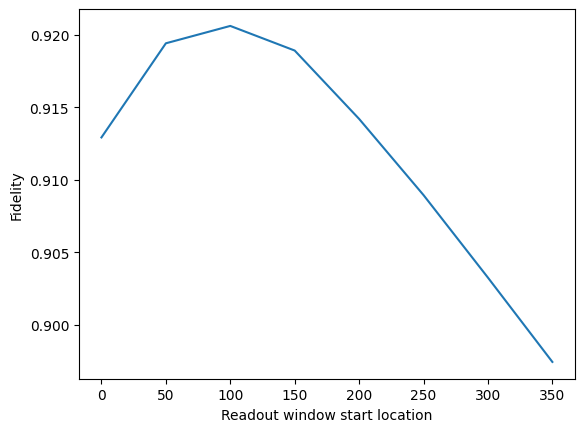

In [112]:
ml_fidelity = 1 - (1 - np.array(ml_e_accuracy)) - (1 - np.array(ml_g_accuracy)) 

plt.figure()
plt.plot(window_start_locations, ml_fidelity)
plt.xlabel('Readout window start location')
plt.ylabel('Fidelity')

print('Accuracy', ml_accuracy)
print('Fidelity', ml_fidelity)

### Single-Layer Model

In [113]:
checkpoint_filename = 'single_layer_model_subwindow.h5'
callbacks = [
        ModelCheckpoint(
        checkpoint_filename,
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        save_freq="epoch",
    ),
    ReduceLROnPlateau(patience=75, min_delta=1**-6),
]

model = Sequential()
model.add(Dense(2, activation='relu', input_shape=(sr,)))
model.add(BatchNormalization())

sl_accuracy, sl_e_accuracy, sl_g_accuracy = scan_readout_window(model, window_start_locations, window_size)

Epoch 1/50
105/105 [==============================] - 2s 11ms/step - loss: 0.3384 - accuracy: 0.8935 - val_loss: 0.2044 - val_accuracy: 0.9497 - lr: 0.0010
Epoch 2/50
105/105 [==============================] - 1s 10ms/step - loss: 0.2277 - accuracy: 0.9545 - val_loss: 0.2005 - val_accuracy: 0.9548 - lr: 0.0010
Epoch 3/50
105/105 [==============================] - 1s 10ms/step - loss: 0.2082 - accuracy: 0.9572 - val_loss: 0.1969 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 4/50
105/105 [==============================] - 1s 10ms/step - loss: 0.1975 - accuracy: 0.9578 - val_loss: 0.1921 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 5/50
105/105 [==============================] - 1s 10ms/step - loss: 0.1906 - accuracy: 0.9580 - val_loss: 0.1878 - val_accuracy: 0.9558 - lr: 0.0010
Epoch 6/50
105/105 [==============================] - 1s 10ms/step - loss: 0.1857 - accuracy: 0.9581 - val_loss: 0.1841 - val_accuracy: 0.9560 - lr: 0.0010
Epoch 7/50
105/105 [==============================] - 1s 10ms/st

Accuracy [0.95765, 0.96008, 0.95982, 0.95773, 0.95521, 0.95263, 0.94974, 0.94706]
Fidelity [0.9153  0.92016 0.91964 0.91546 0.91042 0.90526 0.89948 0.89412]


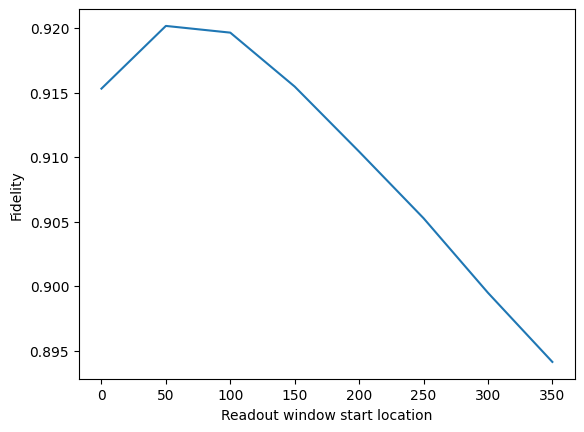

In [114]:
sl_fidelity = 1 - (1 - np.array(sl_e_accuracy)) - (1 - np.array(sl_g_accuracy)) 

plt.figure()
plt.plot(window_start_locations, sl_fidelity)
plt.xlabel('Readout window start location')
plt.ylabel('Fidelity')

print('Accuracy', sl_accuracy)
print('Fidelity', sl_fidelity)